In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Union

In [2]:
# Data cleaning utilities:

# 1. Turn timestamps into a rank.
# DATA_IN    = "clean-raw-2-pid.csv"
# TS, TS_NEW = 'ts', 'ts-new'
# DATA_OUT   = "clean-processed-2-pid.csv"

# data_in = pd.read_csv(DATA_IN)
# data_in[TS_NEW] = data_in[TS].rank(method='dense').astype(int)
# data_in.drop(TS, axis=1, inplace=True)
# data_out = data_in.iloc[:, [5, 0, 1, 2, 3, 4]]
# data_out.rename(columns={TS_NEW: TS}, inplace=True)
# data_out.to_csv(DATA_OUT, index=False)

# 2. Fill in data that vanished
# CLEAN = "clean-processed-pid.csv"
# VANISH = "vanish-0.5-processed-pid.csv"
# OUTPUT = "vanish-0.5-lastvel-pid.csv"
# imputation = {
#     'color': 'yellow',
#     'x': 0,
#     'y': 0,
#     'orientation': 0
# }

# clean = pd.read_csv(CLEAN)
# vanish = pd.read_csv(VANISH)

# complete_index = pd.MultiIndex.from_frame(clean[['ts', 'id']])
# vanish.set_index(['ts', 'id'], inplace=True)
# vanish_new = vanish.reindex(complete_index)
# vanish_new.fillna(value=imputation, inplace=True)
# vanish_new.reset_index(inplace=True)
# vanish_new.sort_values(by=['ts', 'id'], inplace=True)
# vanish_new.to_csv(OUTPUT, index=False)

In [3]:
NO_ROBOTS = 6
ROBOT_RANGE = range(NO_ROBOTS)
NO_ROWS = 900  # Limit window to be analysed
X_AXES = np.arange(NO_ROWS)

CLEAN      = "clean-processed-2-pid.csv"
VANISH_50  = "vanish-0.5-imputed-pid.csv"
LASTVEL_50 = "lastvelocity-0.5-processed-pid.csv"
COMMAND_50 = "command-0.5-processed-pid.csv"

ID_COL, X_COL, Y_COL, TH_COL, V_COL = "id", "x", "y", "orientation", "v"
COLS = [X_COL, Y_COL, TH_COL]
COLS_ALL = COLS + [ID_COL]


def format_data(filename: str, id: bool = True) -> pd.DataFrame:  # for all 6 robots
    data = pd.read_csv(filename)
    if id:
        return data[COLS_ALL]
    return data[COLS].iloc[:NO_ROWS]


CLEAN_FD      = format_data(CLEAN)
VANISH_50_FD  = format_data(VANISH_50)
LASTVEL_50_FD = format_data(LASTVEL_50)
COMMAND_50_FD = format_data(COMMAND_50)


def extract_robot(data: pd.DataFrame, id: int) -> pd.DataFrame:
    return data[data[ID_COL]==id].iloc[:NO_ROWS].drop(ID_COL, axis=1).reset_index(drop=True)


cleans      = [extract_robot(CLEAN_FD, id) for id in ROBOT_RANGE]
vanish_50s  = [extract_robot(VANISH_50_FD, id) for id in ROBOT_RANGE]
lastvel_50s = [extract_robot(LASTVEL_50_FD, id) for id in ROBOT_RANGE]
command_50s = [extract_robot(COMMAND_50_FD, id) for id in ROBOT_RANGE]


def get_current_ax(axs: np.ndarray, id: int) -> plt.Axes:
    return axs[id//3][id%3]

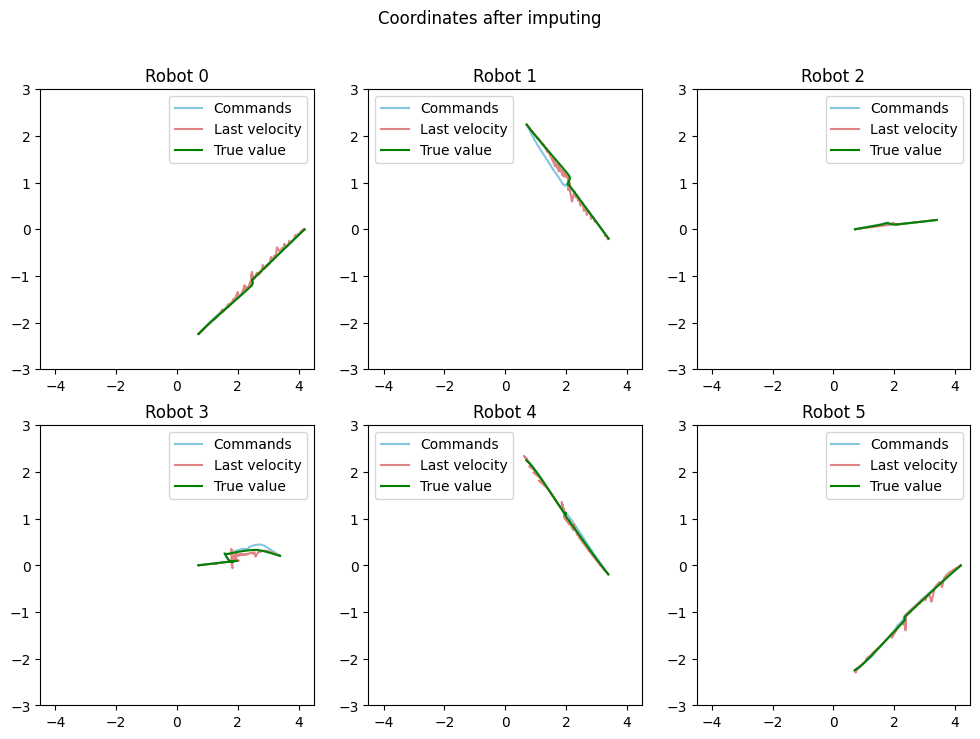

In [4]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("Coordinates after imputing")

for id in ROBOT_RANGE:
    clean = cleans[id]
    lastvel_50 = lastvel_50s[id]
    command_50 = command_50s[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.set_xlim(-4.5, 4.5)
    current_ax.set_ylim(-3, 3)
    
    current_ax.plot(lastvel_50[X_COL], lastvel_50[Y_COL], "#84c6de")
    current_ax.plot(command_50[X_COL], command_50[Y_COL], "#de8484")
    current_ax.plot(clean[X_COL], clean[Y_COL], "g")
    
    current_ax.legend(("Commands", "Last velocity", "True value"))

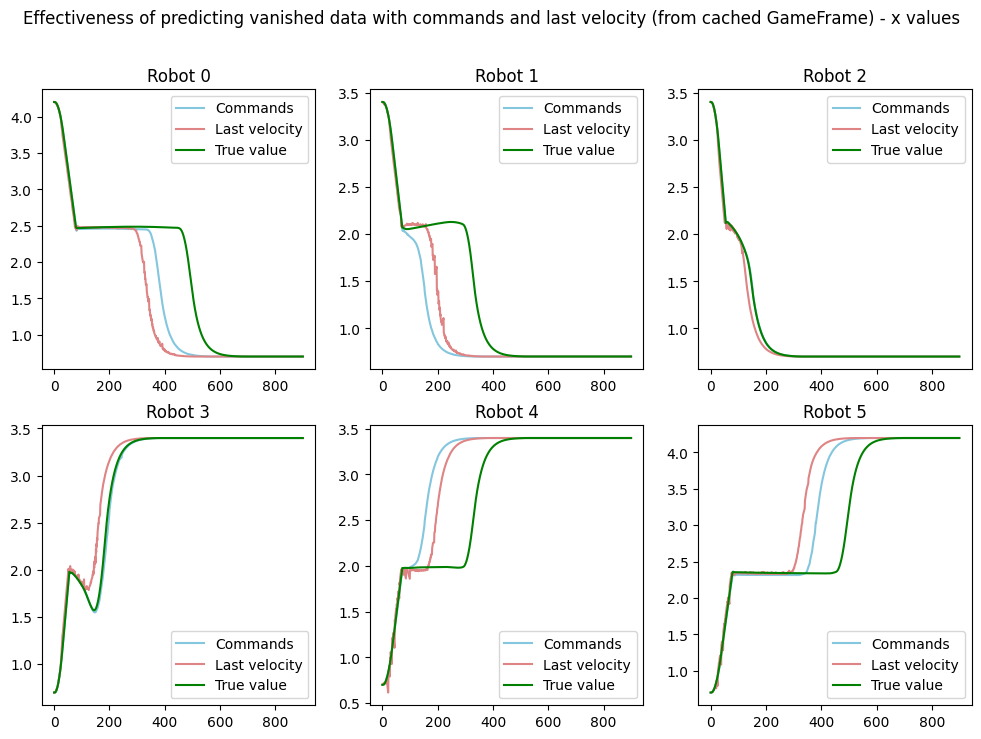

In [5]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("Effectiveness of predicting vanished data with commands and last velocity (from cached GameFrame) - x values")

for id in ROBOT_RANGE:
    clean = cleans[id]
    lastvel_50 = lastvel_50s[id]
    command_50 = command_50s[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.plot(X_AXES, lastvel_50[X_COL], "#84c6de")
    current_ax.plot(X_AXES, command_50[X_COL], "#de8484")
    current_ax.plot(X_AXES, clean[X_COL], "g")
    
    current_ax.legend(("Commands", "Last velocity", "True value"))

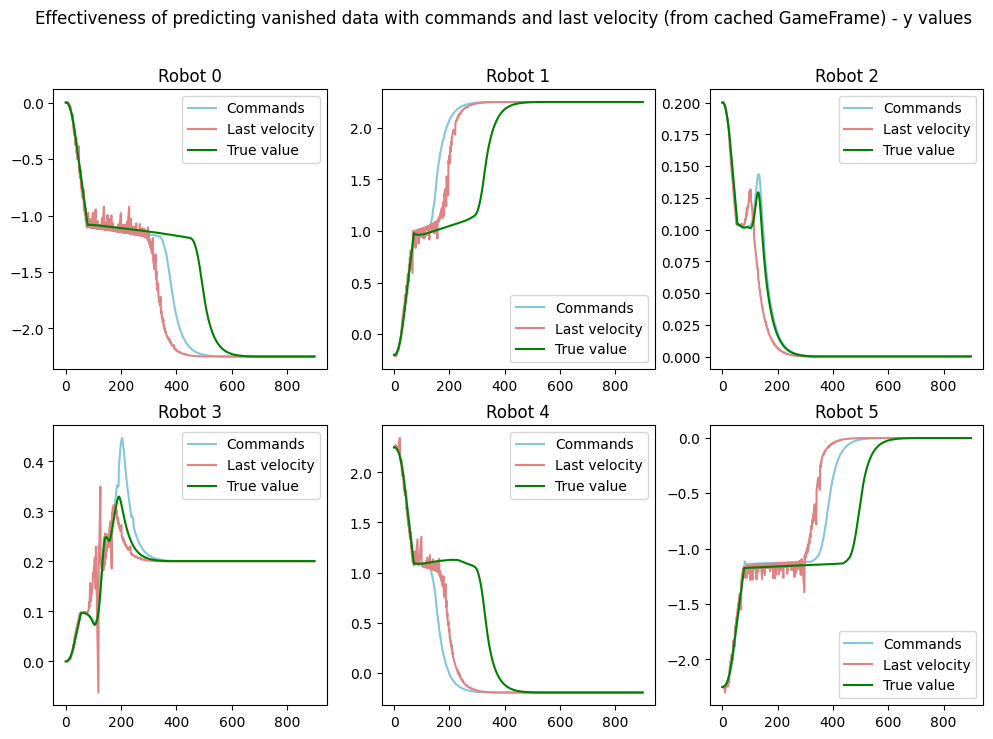

In [6]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("Effectiveness of predicting vanished data with commands and last velocity (from cached GameFrame) - y values")

for id in ROBOT_RANGE:
    clean = cleans[id]
    lastvel_50 = lastvel_50s[id]
    command_50 = command_50s[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.plot(X_AXES, lastvel_50[Y_COL], "#84c6de")
    current_ax.plot(X_AXES, command_50[Y_COL], "#de8484")
    current_ax.plot(X_AXES, clean[Y_COL], "g")
    
    current_ax.legend(("Commands", "Last velocity", "True value"))

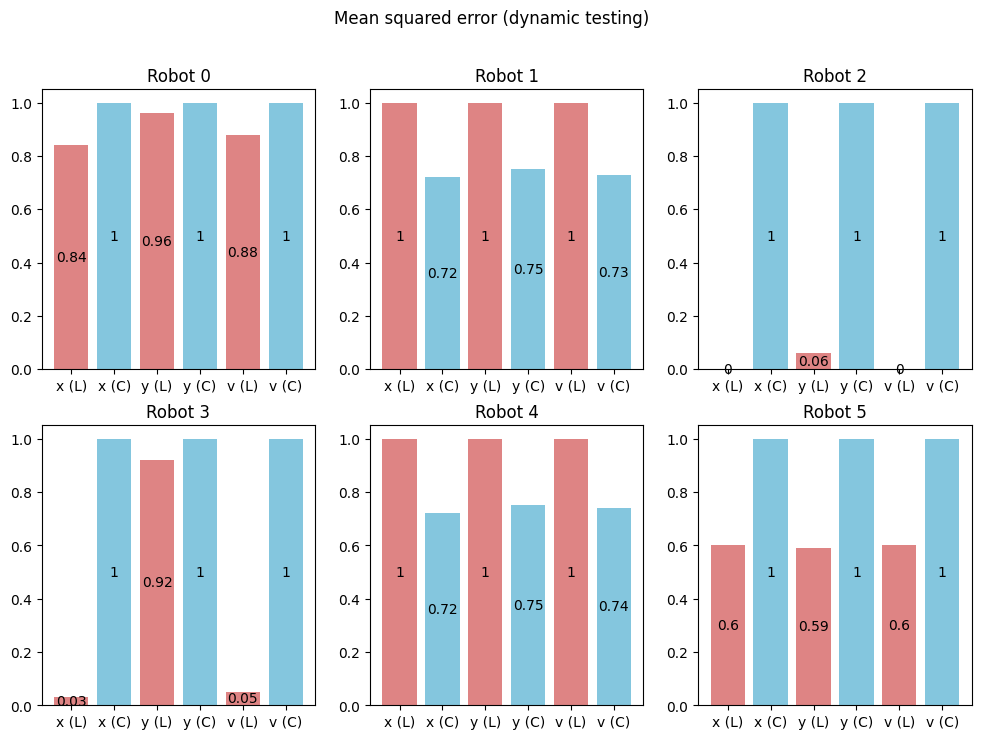

In [7]:
def diff_squared(t: float, a: float) -> float:
    return (t - a) ** 2


def mean_squared_error(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str,
    id: Union[int, None] = None
    ) -> float:
    if id:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
        
    return true_data[param].combine(
            other=actual_data[param],
            func=diff_squared
        ).mean()


def vectorify(x: float, y: float) -> np.ndarray:
    return np.array((x, y))


def mean_squared_error_vec(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    id: Union[int, None] = None
    ) -> float:
    if id:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
    
    true_vec = true_data[X_COL].combine(
        other=true_data[Y_COL],
        func=vectorify
    )
    
    actual_vec = actual_data[X_COL].combine(
        other=actual_data[Y_COL],
        func=vectorify
    )
    
    return (np.linalg.norm(true_vec - actual_vec) ** 2).mean()


fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("Mean squared error (dynamic testing)")

for id in ROBOT_RANGE:
    lastvel_error_x = mean_squared_error(
        CLEAN_FD,
        LASTVEL_50_FD,
        X_COL,
        id
    )
    
    lastvel_error_y = mean_squared_error(
        CLEAN_FD,
        LASTVEL_50_FD,
        Y_COL,
        id
    )
    
    lastvel_error_v = mean_squared_error_vec(
        CLEAN_FD,
        LASTVEL_50_FD,
        id
    )
    
    commands_error_x = mean_squared_error(
        CLEAN_FD,
        COMMAND_50_FD,
        X_COL,
        id
    )
    
    commands_error_y = mean_squared_error(
        CLEAN_FD,
        COMMAND_50_FD,
        Y_COL,
        id
    )
    
    commands_error_v = mean_squared_error_vec(
        CLEAN_FD,
        COMMAND_50_FD,
        id
    )
    
    max_x_error = max(lastvel_error_x, commands_error_x)
    max_y_error = max(lastvel_error_y, commands_error_y)
    max_v_error = max(lastvel_error_v, commands_error_v)
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    
    errors = [round(lastvel_error_x/max_x_error, 2), round(commands_error_x/max_x_error, 2),
              round(lastvel_error_y/max_y_error, 2), round(commands_error_y/max_y_error, 2),
              round(lastvel_error_v/max_v_error, 2), round(commands_error_v/max_v_error, 2)]
    colours = ['#de8484', '#84c6de'] * 3
    impute, command = " (L)", " (C)"
    bars = current_ax.bar([X_COL + impute, X_COL + command,
                           Y_COL + impute, Y_COL + command,
                           V_COL + impute, V_COL + command], errors, color=colours)
    current_ax.bar_label(bars, label_type='center')

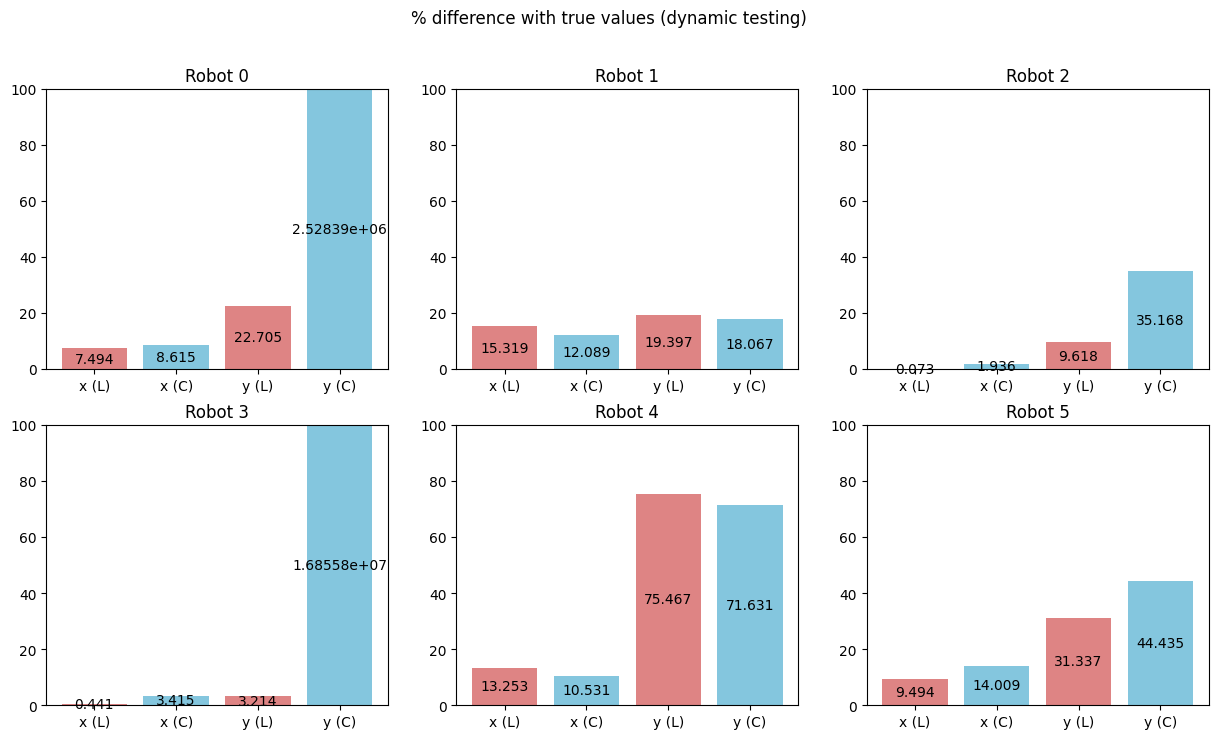

In [8]:
def abs_percentage_diff(
    old: float,
    new: float
) -> float:
    return abs(round((new-old) / old * 100, 3))


def mean_abs_percentage_diff(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str,
    id: Union[int, None] = None
    ) -> float:
    if id:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
        
    return round(true_data[param].combine(
            other=actual_data[param],
            func=abs_percentage_diff
        ).mean(), 3)


fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("% difference with true values (dynamic testing)")

for id in ROBOT_RANGE:
    lastvel_error_x = mean_abs_percentage_diff(
        CLEAN_FD,
        LASTVEL_50_FD,
        X_COL,
        id
    )
    
    lastvel_error_y = mean_abs_percentage_diff(
        CLEAN_FD,
        LASTVEL_50_FD,
        Y_COL,
        id
    )
    
    command_error_x = mean_abs_percentage_diff(
        CLEAN_FD,
        COMMAND_50_FD,
        X_COL,
        id
    )
    
    command_error_y = mean_abs_percentage_diff(
        CLEAN_FD,
        COMMAND_50_FD,
        Y_COL,
        id
    )
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.set_ylim(0, 100)
    
    deltas = [lastvel_error_x, command_error_x,
              lastvel_error_y, command_error_y]
    colours = ['#de8484', '#84c6de'] * 2
    impute, command = " (L)", " (C)"
    bars = current_ax.bar([X_COL + impute, X_COL + command,
                           Y_COL + impute, Y_COL + command], deltas, color=colours)
    current_ax.bar_label(bars, label_type='center')

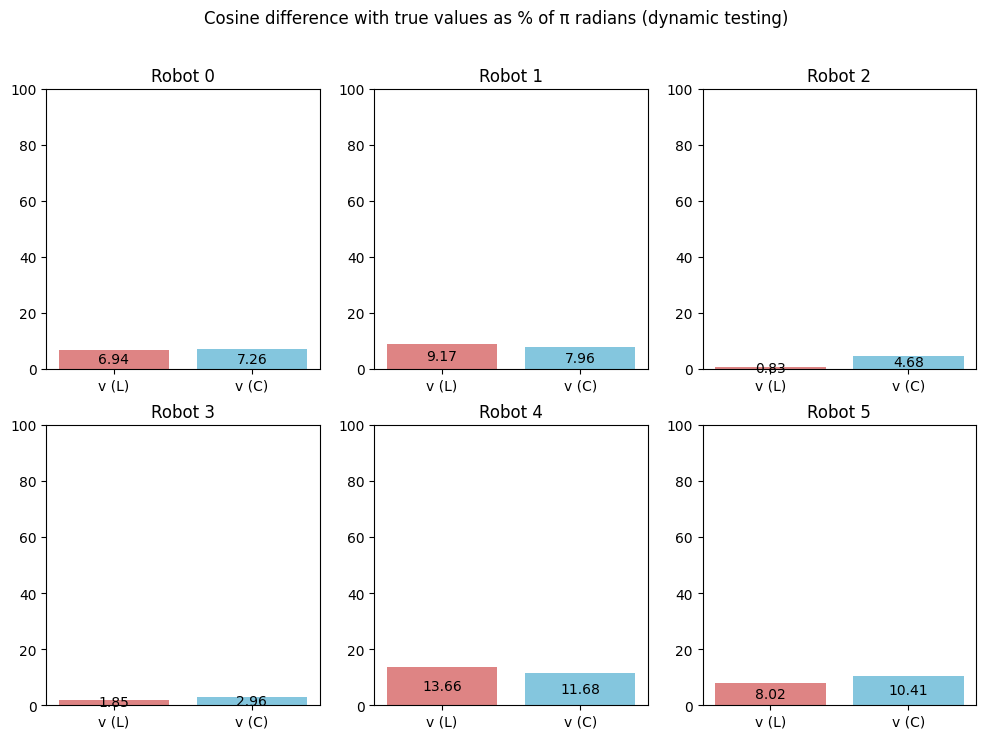

In [9]:
def cosine_diff(
    a: np.ndarray,
    b: np.ndarray
) -> float:
    return np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))


def mean_cosine_diff(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    id: Union[int, None] = None
    ) -> float:
    if id:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
    
    true_vec = true_data[X_COL].combine(
        other=true_data[Y_COL],
        func=vectorify
    )
    
    actual_vec = actual_data[X_COL].combine(
        other=actual_data[Y_COL],
        func=vectorify
    )
    
    return round(cosine_diff(actual_vec, true_vec).mean(), 3)


fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("Cosine difference with true values as % of π radians (dynamic testing)")

for id in ROBOT_RANGE:
    lastvel_error_v = mean_cosine_diff(
        CLEAN_FD,
        LASTVEL_50_FD,
        id
    )
    
    command_error_v = mean_cosine_diff(
        CLEAN_FD,
        COMMAND_50_FD,
        id
    )
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.set_ylim(0, 100)
    
    deltas = [round(lastvel_error_v * 100/np.pi, 2), round(command_error_v * 100/np.pi, 2)]
    colours = ['#de8484', '#84c6de']
    impute, command = " (L)", " (C)"
    bars = current_ax.bar([V_COL + impute, V_COL + command], deltas, color=colours)
    current_ax.bar_label(bars, label_type='center')

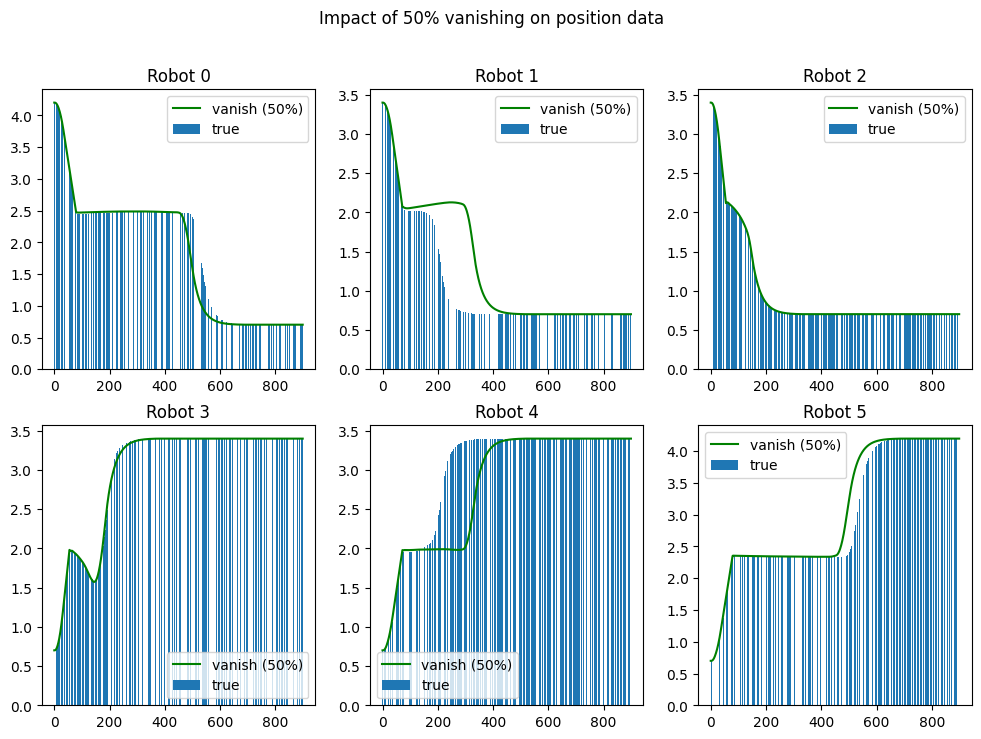

In [10]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("Impact of 50% vanishing on position data")

for id in ROBOT_RANGE:
    clean = cleans[id]
    vanish_50 = vanish_50s[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.bar(X_AXES, vanish_50[X_COL])
    current_ax.plot(X_AXES, clean[X_COL], "g")
    
    current_ax.legend(("vanish (50%)", "true"))